https://www.kaggle.com/pranavraikokte/covid19-image-dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import importlib
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3688)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
# Step 1: Loading in Dataset
ds_directory = '/home/zrarnz/9-Projects/ECET380/IntelImageSceneClassification/train'
os.listdir(ds_directory)
ts_directory = '/home/zrarnz/9-Projects/ECET380/IntelImageSceneClassification/test'
ad_active = "softsign"

In [4]:
# Load in ordered dataset
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
train_set = image_dataset_from_directory(ds_directory,
                        shuffle=True,
                        validation_split=0.2,
                        subset="training",
                        seed=123,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')


Found 14034 files belonging to 6 classes.
Using 11228 files for training.


In [5]:
val_set = image_dataset_from_directory(ds_directory,
                        shuffle=True,
                        validation_split=0.2,
                        subset="validation",
                        seed=123,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')

Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [6]:
test_set = image_dataset_from_directory(ts_directory,
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')

Found 3000 files belonging to 6 classes.


In [7]:
train_set.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [8]:
# dataset_size = 181
# batch_size = BATCH_SIZE

def preprocess(image, label):
    # resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.efficientnet.preprocess_input(image)
    return final_image, label

# train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).prefetch(1)
val_set = val_set.map(preprocess).prefetch(1)
test_set = test_set.map(preprocess).prefetch(1)

In [9]:
print('Number of fullset batches: %d' % tf.data.experimental.cardinality(train_set))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of fullset batches: 702
Number of validation batches: 176
Number of test batches: 188


In [10]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                                  input_tensor=None,
                                               include_top=False,
                                               pooling=None,
                                                classes=1000,
                                               weights='imagenet')

In [11]:
for layer in base_model.layers:
    layer.trainable = False

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
ad_layer = keras.layers.Dense(
    units = 12,
    activation = ad_active)(avg)
dropout = keras.layers.Dropout(0.32)(ad_layer)
output = keras.layers.Dense(
    units = 6, 
    activation = "softmax")(dropout)

model = keras.models.Model(
    inputs = base_model.input,
    outputs = output)

model.compile(
    optimizer = keras.optimizers.SGD(
        learning_rate = 0.02,
        ),
    loss = "sparse_categorical_crossentropy", 
    metrics = ['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [12]:
# tuner = kt.RandomSearch(
#             model_builder,
#             objective='val_accuracy',
#             max_trials=27,
#             seed=0,
#             overwrite=True,
#             executions_per_trial=2)

In [13]:
pre_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
pre_chckp = keras.callbacks.ModelCheckpoint("effdetb0_" + ad_active + "_intelscene_pretune.h5", save_best_only=True)

In [14]:
len(model.trainable_variables)


4

In [15]:
model.fit(train_set,
            validation_data=val_set,
            epochs=32,
            callbacks=[pre_early, pre_chckp],
#             steps_per_epoch=int(0.75 * DATASET_SIZE / BATCH_SIZE),
#             validation_steps=int(0.15 * DATASET_SIZE / BATCH_SIZE),
            )

Epoch 1/32
702/702 [==============================] - 93s 117ms/step - loss: 0.8967 - accuracy: 0.7251 - val_loss: 0.3514 - val_accuracy: 0.8995
Epoch 2/32
702/702 [==============================] - 79s 112ms/step - loss: 0.3936 - accuracy: 0.8877 - val_loss: 0.2651 - val_accuracy: 0.9145
Epoch 3/32
702/702 [==============================] - 84s 120ms/step - loss: 0.3367 - accuracy: 0.8953 - val_loss: 0.2345 - val_accuracy: 0.9198
Epoch 4/32
702/702 [==============================] - 85s 120ms/step - loss: 0.2971 - accuracy: 0.9076 - val_loss: 0.2208 - val_accuracy: 0.9227
Epoch 5/32
702/702 [==============================] - 82s 117ms/step - loss: 0.2822 - accuracy: 0.9119 - val_loss: 0.2096 - val_accuracy: 0.9252
Epoch 6/32
702/702 [==============================] - 84s 120ms/step - loss: 0.2779 - accuracy: 0.9081 - val_loss: 0.2050 - val_accuracy: 0.9262
Epoch 7/32
702/702 [==============================] - 84s 120ms/step - loss: 0.2508 - accuracy: 0.9234 - val_loss: 0.2007 - val_ac

In [16]:
model.evaluate(test_set)

188/188 [==============================] - 20s 105ms/step - loss: 0.2109 - accuracy: 0.9183


[0.21085596084594727, 0.9183333516120911]

In [17]:

train_set = train_set.shuffle(1000)


In [18]:
print('Number of fullset batches: %d' % tf.data.experimental.cardinality(train_set))


print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of fullset batches: 702
Number of validation batches: 176
Number of test batches: 188


In [19]:
model2 = keras.models.load_model("effdetb0_" + ad_active + "_intelscene_pretune.h5")

In [20]:
for layer in model2.layers:
        layer.trainable=True

In [21]:
optimizer2 = keras.optimizers.SGD(learning_rate=0.002)

In [22]:
post_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
post_chckp = keras.callbacks.ModelCheckpoint("effdetb0_" + ad_active + "_intelscene_posttune.h5", save_best_only=True)

In [23]:
model2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer2,
    metrics="accuracy"
)

In [24]:
history = model2.fit(
    train_set,
    validation_data=val_set,
    epochs=64,
    callbacks=[post_early, post_chckp]
)

Epoch 1/64
702/702 [==============================] - 297s 384ms/step - loss: 0.7158 - accuracy: 0.7354 - val_loss: 0.2737 - val_accuracy: 0.9016
Epoch 2/64
702/702 [==============================] - 256s 347ms/step - loss: 0.4389 - accuracy: 0.8470 - val_loss: 0.2383 - val_accuracy: 0.9220
Epoch 3/64
702/702 [==============================] - 253s 346ms/step - loss: 0.3794 - accuracy: 0.8719 - val_loss: 0.2192 - val_accuracy: 0.9334
Epoch 4/64
702/702 [==============================] - 251s 343ms/step - loss: 0.3363 - accuracy: 0.8876 - val_loss: 0.2110 - val_accuracy: 0.9348
Epoch 5/64
702/702 [==============================] - 251s 342ms/step - loss: 0.3190 - accuracy: 0.8928 - val_loss: 0.2041 - val_accuracy: 0.9355
Epoch 6/64
702/702 [==============================] - 251s 342ms/step - loss: 0.2857 - accuracy: 0.9089 - val_loss: 0.2008 - val_accuracy: 0.9341
Epoch 7/64
702/702 [==============================] - 251s 342ms/step - loss: 0.2760 - accuracy: 0.9126 - val_loss: 0.1967 -

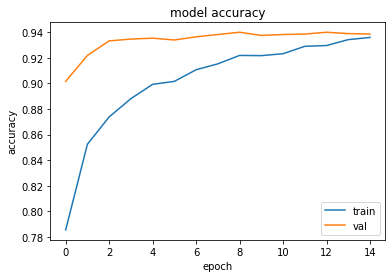

In [25]:
fig_acc = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

In [ ]:
model2.evaluate(test_set)

 17/188 [=>............................] - ETA: 14s - loss: 0.2165 - accuracy: 0.9191

In [ ]:
evalPipe=test_set
for feats,lab in evalPipe.unbatch().batch(6000).take(1):
	probPreds=model2.predict(feats)

top1err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=1))
top5err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=5))
top10err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=10))
print(top10err, top5err, top1err)